This will save files to your local machine if `save_files` is set to True.

# Change Inputs Here

In [ ]:
task = "numwords"  # choose: numerals, numwords, months
prompt_types = ['done', 'lost', 'names']
num_samps_per_ptype = 512 #768 512

model_name = "gpt2-small"

save_files = True
run_on_other_tasks = True

# Setup

In [ ]:
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-riodbozl
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-riodbozl
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 829084a53836c5b8b388aa37a5ffce73b6371712
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
# import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

import pickle
from google.colab import files

import matplotlib.pyplot as plt
import statistics

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [ ]:
torch.set_grad_enabled(False)

## Load Model

In [ ]:
model = HookedTransformer.from_pretrained(
    model_name,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


## Import functions from repo

In [ ]:
!git clone https://github.com/wlg1/seqcont_circ_expms.git

Cloning into 'seqcont_circ_expms'...
remote: Enumerating objects: 351, done.
remote: Counting objects: 100% (351/351), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 351 (delta 222), reused 308 (delta 182), pack-reused 0
Receiving objects: 100% (351/351), 15.01 MiB | 6.76 MiB/s, done.
Resolving deltas: 100% (222/222), done.


In [ ]:
%cd /content/seqcont_circ_expms

/content/seqcont_circ_expms


In [ ]:
from dataset import Dataset
from generate_data import *
from metrics import *
from head_ablation_fns import *
from mlp_ablation_fns import *
from node_ablation_fns import *
from loop_node_ablation_fns import *

# Load datasets

In [ ]:
prompts_list = []

for i in prompt_types:
    file_name = f'/content/seqcont_circ_expms/data/{task}/{task}_prompts_{i}.pkl'
    with open(file_name, 'rb') as file:
        filelist = pickle.load(file)

    print(filelist[0]['text'])
    prompts_list += filelist [:num_samps_per_ptype]

len(prompts_list)

Van done in one. Hat done in two. Ring done in three. Desk done in four. Sun done in
Oil lost in one. Apple lost in two. Tree lost in three. Snow lost in four. Apple lost in
Marcus born in one. Victoria born in two. George born in three. Brandon born in four. Jamie born in


1536

In [ ]:
pos_dict = {}
for i in range(len(model.tokenizer.tokenize(prompts_list[0]['text']))):
    pos_dict['S'+str(i)] = i

In [ ]:
dataset = Dataset(prompts_list, pos_dict, model.tokenizer)

In [ ]:
file_name = f'/content/seqcont_circ_expms/data/{task}/randDS_{task}.pkl'
with open(file_name, 'rb') as file:
    prompts_list_2 = pickle.load(file)

In [ ]:
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer)

## Get orig score

In [ ]:
model.reset_hooks(including_permanent=True)
ioi_logits_original = model(dataset.toks)
orig_score = get_logit_diff(ioi_logits_original, dataset)

In [ ]:
import gc

del(ioi_logits_original)
torch.cuda.empty_cache()
gc.collect()

60

# Find Impt Attention Heads from Full

In [17]:
circ = [(layer, head) for layer in range(12) for head in range(12)]
to_loop = [(layer, head) for layer in range(12) for head in range(12)]

lh_scores = {}
for lh in to_loop:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = ablate_head_from_full(copy_circuit, model, dataset, dataset_2, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

removed: (0, 0)
Average logit difference (circuit / full) %: 100.9832
removed: (0, 1)
Average logit difference (circuit / full) %: 8.1006
removed: (0, 2)
Average logit difference (circuit / full) %: 100.4444
removed: (0, 3)
Average logit difference (circuit / full) %: 100.1392
removed: (0, 4)
Average logit difference (circuit / full) %: 102.1836
removed: (0, 5)
Average logit difference (circuit / full) %: 94.9820
removed: (0, 6)
Average logit difference (circuit / full) %: 103.1773
removed: (0, 7)
Average logit difference (circuit / full) %: 101.7027
removed: (0, 8)
Average logit difference (circuit / full) %: 100.7235
removed: (0, 9)
Average logit difference (circuit / full) %: 98.2363
removed: (0, 10)
Average logit difference (circuit / full) %: 104.2154
removed: (0, 11)
Average logit difference (circuit / full) %: 99.9846
removed: (1, 0)
Average logit difference (circuit / full) %: 102.1491
removed: (1, 1)
Average logit difference (circuit / full) %: 101.0809
removed: (1, 2)
Average

In [18]:
# Sort the dictionary by values in descending order
sorted_lh_scores = sorted(lh_scores.items(), key=lambda item: -item[1], reverse=True)

# Iterate over the top 10 items and print them
for lh, score in sorted_lh_scores[:10]:
    modified_score = -round(100 - score, 2)
    print(lh, modified_score)

(0, 1) -91.9
(7, 11) -61.51
(4, 4) -52.08
(1, 5) -38.03
(9, 1) -29.93
(6, 10) -25.01
(10, 7) -21.19
(1, 11) -16.99
(8, 8) -14.68
(6, 6) -14.44


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

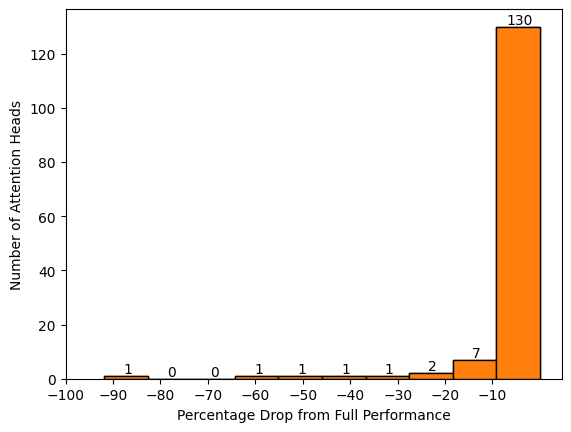

In [19]:
lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores.items()}
scores = list(lh_scores_drop.values())
plt.hist(scores, bins=10, edgecolor='black')
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Annotating the histogram with the number of values in each bin
for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

plt.xticks(range(-100, 0, 10))
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
# plt.title('Distribution of Attention Head Performance Drop Percentages')

# plt.show()

if save_files:
    pdf_filename = 'lh_scores_distribution.pdf'
    plt.savefig(pdf_filename)
    files.download(pdf_filename)

In [20]:
scores = list(lh_scores_drop.values())
mean_score = statistics.mean(scores)
print("Mean of the scores:", mean_score)
if save_files:
    with open('numerals_lh_scores.pkl', 'wb') as file:
        pickle.dump(lh_scores, file)
        files.download('numerals_lh_scores.pkl')

Mean of the scores: -3.4924875034226313


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Find Impt MLPs from Full

In [21]:
for i in range(12):
    lst = [layer for layer in range(12) if layer != i]
    perc_of_orig = ablate_MLP_from_full(lst, model, dataset, dataset_2, orig_score, print_output=False).item()
    print(i, perc_of_orig)

0 4.0249505043029785
1 65.28792572021484
2 79.81611633300781
3 81.80935668945312
4 50.76289749145508
5 74.83795166015625
6 66.5409164428711
7 70.29489135742188
8 56.82688522338867
9 15.896557807922363
10 57.913150787353516
11 75.0255355834961


# Node Ablation Iteration

In [22]:
threshold = 20
curr_circ_heads = []
curr_circ_mlps = []
prev_score = 100
new_score = 0
iter = 1
all_comp_scores = []
while prev_score != new_score:
    print('\nbackw prune, iter ', str(iter))
    old_circ_heads = curr_circ_heads.copy() # save old before finding new one
    old_circ_mlps = curr_circ_mlps.copy()
    curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
    if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
        break
    all_comp_scores.append(comp_scores)
    print('\nfwd prune, iter ', str(iter))
    # track changes in circuit as for some reason it doesn't work with scores
    old_circ_heads = curr_circ_heads.copy()
    old_circ_mlps = curr_circ_mlps.copy()
    curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_forw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
    if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
        break
    all_comp_scores.append(comp_scores)
    iter += 1


backw prune, iter  1
11
(cand circuit / full) %: 75.0255
11 0
(cand circuit / full) %: 99.7315
Removed: (11, 0)
11 1
(cand circuit / full) %: 99.8717
Removed: (11, 1)
11 2
(cand circuit / full) %: 99.8522
Removed: (11, 2)
11 3
(cand circuit / full) %: 99.9779
Removed: (11, 3)
11 4
(cand circuit / full) %: 99.5896
Removed: (11, 4)
11 5
(cand circuit / full) %: 99.6130
Removed: (11, 5)
11 6
(cand circuit / full) %: 99.6287
Removed: (11, 6)
11 7
(cand circuit / full) %: 99.5665
Removed: (11, 7)
11 8
(cand circuit / full) %: 99.2456
Removed: (11, 8)
11 9
(cand circuit / full) %: 98.4471
Removed: (11, 9)
11 10
(cand circuit / full) %: 97.2846
Removed: (11, 10)
11 11
(cand circuit / full) %: 97.5267
Removed: (11, 11)
10
(cand circuit / full) %: 55.1619
10 0
(cand circuit / full) %: 97.5296
Removed: (10, 0)
10 1
(cand circuit / full) %: 96.6200
Removed: (10, 1)
10 2
(cand circuit / full) %: 103.0986
Removed: (10, 2)
10 3
(cand circuit / full) %: 103.1752
Removed: (10, 3)
10 4
(cand circuit /

In [23]:
with open('numerals_bf_20_scores.pkl', 'wb') as file:
    pickle.dump(all_comp_scores, file)
files.download('numerals_bf_20_scores.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
curr_circ_heads

[(0, 1),
 (1, 5),
 (4, 4),
 (4, 10),
 (5, 8),
 (6, 1),
 (6, 6),
 (6, 10),
 (7, 2),
 (7, 6),
 (7, 11),
 (8, 1),
 (8, 6),
 (8, 8),
 (8, 9),
 (8, 11),
 (9, 1),
 (9, 5),
 (9, 7)]

In [25]:
curr_circ_mlps

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

## Find most impt heads from circ

In [26]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, curr_circ_heads, curr_circ_mlps)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 81.1096


In [27]:
lh_scores = {}
for lh in curr_circ_heads:
    copy_circuit = curr_circ_heads.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
    model = add_ablation_hook_MLP_head(model, dataset_2, copy_circuit, curr_circ_mlps)

    new_logits = model(dataset.toks)
    new_score = get_logit_diff(new_logits, dataset).item()
    new_perc = 100 * new_score / orig_score
    print(f"(cand circuit / full) %: {new_perc:.4f}")
    lh_scores[lh] = new_perc

removed: (0, 1)
(cand circuit / full) %: 2.3691
removed: (1, 5)
(cand circuit / full) %: 62.4586
removed: (4, 4)
(cand circuit / full) %: 46.9987
removed: (4, 10)
(cand circuit / full) %: 75.3836
removed: (5, 8)
(cand circuit / full) %: 75.9623
removed: (6, 1)
(cand circuit / full) %: 76.6214
removed: (6, 6)
(cand circuit / full) %: 71.4101
removed: (6, 10)
(cand circuit / full) %: 56.8324
removed: (7, 2)
(cand circuit / full) %: 78.2655
removed: (7, 6)
(cand circuit / full) %: 76.1487
removed: (7, 11)
(cand circuit / full) %: 36.3295
removed: (8, 1)
(cand circuit / full) %: 68.5016
removed: (8, 6)
(cand circuit / full) %: 74.8917
removed: (8, 8)
(cand circuit / full) %: 67.9027
removed: (8, 9)
(cand circuit / full) %: 77.7477
removed: (8, 11)
(cand circuit / full) %: 70.2452
removed: (9, 1)
(cand circuit / full) %: 53.3702
removed: (9, 5)
(cand circuit / full) %: 75.2664
removed: (9, 7)
(cand circuit / full) %: 78.0327


In [28]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score.item(), 2))

(0, 1) -78.74
(7, 11) -44.78
(4, 4) -34.11
(9, 1) -27.74
(6, 10) -24.28
(1, 5) -18.65
(8, 8) -13.21
(8, 1) -12.61
(8, 11) -10.86
(6, 6) -9.7
(8, 6) -6.22
(9, 5) -5.84
(4, 10) -5.73
(5, 8) -5.15
(7, 6) -4.96
(6, 1) -4.49
(8, 9) -3.36
(9, 7) -3.08
(7, 2) -2.84


# Run on other task's circuits

In [29]:
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 0), (6, 1), (6, 6), (6, 10), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 48.4090


In [30]:
# numwords
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 8), (6, 1), (6, 6), (6, 10), (7, 2), (7, 6), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (8, 11), (9, 1), (9, 5), (9, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 81.1096


In [31]:
# months
heads_not_ablate = [(0, 1), (0, 5), (4, 4), (6, 1), (6, 6), (6, 10), (7, 6), (7, 9), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 32.3630


In [32]:
CIRCUIT = {
    "name mover": [(9, 9), (10, 0), (9, 6)],
    "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    "negative name mover": [(10, 7), (11, 10)],
    "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    "duplicate token": [(0, 1), (0, 10), (3, 0)],
    "previous token": [(2, 2), (4, 11)],
}

import itertools
a = [val for val in CIRCUIT.values()]
IOI_heads = list(itertools.chain.from_iterable(a))

mlps_not_ablate = list(range(12))

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, IOI_heads, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: -15.8257


In [33]:
### months w/ MLP 11

heads_not_ablate = [(0, 1), (4, 4), (4, 10), (6, 1), (6, 6), (6, 10), (7, 2), (7, 10), (7, 11), (8, 8), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11] # incl 5 makes it 66.1155%

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 21.8885
